In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/flight-price-prediction/business.csv
/kaggle/input/flight-price-prediction/economy.csv
/kaggle/input/flight-price-prediction/Clean_Dataset.csv


## Flight Price Prediction Using Linear and Regression Models

### Table of Contents
#### 1. Importing Libraries and Dataset
#### 2. Data Cleaning and Preprocessing
#### 3. Exploratory Data Analysis (EDA)
#### 4. Feature Engineering
#### 5. Model Building
        5.1. Linear Regression      
        5.2. Ridge Regression       
        5.3. Lasso       
        5.4. Random Forest Regressor       
        5.5. Gradient Boost Regressor        
        5.6. XGB Regressor      
        5.7. CatBoost Regressor
#### 6. Results and Evaluation

### 1. Importing Libraires and Dataset

In [ ]:
import seaborn as sns
import matplotlib.pylab as plt
import matplotlib
import datetime as dt
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
matplotlib.rcParams['font.size']=12
matplotlib.rcParams['figure.figsize']=(10,6)
sns.set()
plt.style.use('ggplot')

pd.set_option('display.max_columns', None)

from sklearn.metrics import r2_score, mean_absolute_error,mean_squared_error
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

In [115]:
df=pd.read_csv('/kaggle/input/flight-price-prediction/Clean_Dataset.csv')

In [4]:
df.head()

,Unnamed: 0,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


The values in **'price'** column are shown as **Indian Rupees (₹)**.

### 2. Data Cleaning and Preprocessing

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300153 entries, 0 to 300152
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   airline           300153 non-null  object 
 1   flight            300153 non-null  object 
 2   source_city       300153 non-null  object 
 3   departure_time    300153 non-null  object 
 4   stops             300153 non-null  object 
 5   arrival_time      300153 non-null  object 
 6   destination_city  300153 non-null  object 
 7   class             300153 non-null  object 
 8   duration          300153 non-null  float64
 9   days_left         300153 non-null  int64  
 10  price             300153 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 25.2+ MB


In [116]:
df.drop('Unnamed: 0',axis=1,inplace=True)

In [7]:
df.describe()

,duration,days_left,price
count,300153.000000,300153.000000,300153.000000
mean,12.221021,26.004751,20889.660523
std,7.191997,13.561004,22697.767366
min,0.830000,1.000000,1105.000000
25%,6.830000,15.000000,4783.000000
50%,11.250000,26.000000,7425.000000
75%,16.170000,38.000000,42521.000000
max,49.830000,49.000000,123071.000000


In [8]:
df.describe(include='object')

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class
count,300153,300153,300153,300153,300153,300153,300153,300153
unique,6,1561,6,6,3,6,6,2
top,Vistara,UK-706,Delhi,Morning,one,Night,Mumbai,Economy
freq,127859,3235,61343,71146,250863,91538,59097,206666


In [9]:
df.isnull().sum()

airline             0
flight              0
source_city         0
departure_time      0
stops               0
arrival_time        0
destination_city    0
class               0
duration            0
days_left           0
price               0
dtype: int64

In [10]:
df[df.duplicated()]

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price


There are no **null** or **duplicated** values in our dataset.

### 3. Exploratory Data Analysis (EDA)

In [11]:
df.columns

Index(['airline', 'flight', 'source_city', 'departure_time', 'stops',
       'arrival_time', 'destination_city', 'class', 'duration', 'days_left',
       'price'],
      dtype='object')

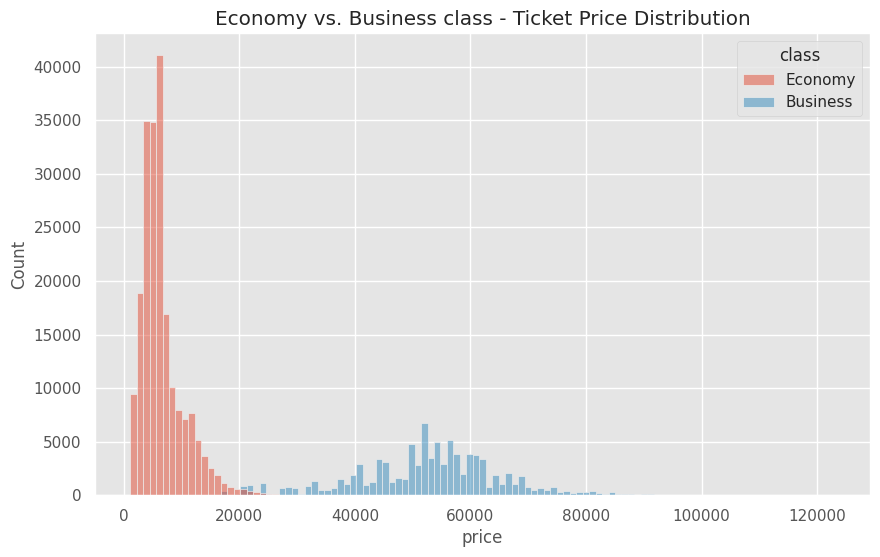

In [64]:
sns.histplot(data=df,x='price',hue='class')
plt.title('Economy vs. Business class - Ticket Price Distribution')
plt.show()

From the histogram, we observe that the price data is **right-skewed** for both classes.   
Economy class tickets are concentrated in the lower price range, with most prices falling between **5,000 and 6,000**.   
In contrast, Business class fares are significantly higher—on average about 10 times more expensive, with most prices centered around **50,000**.

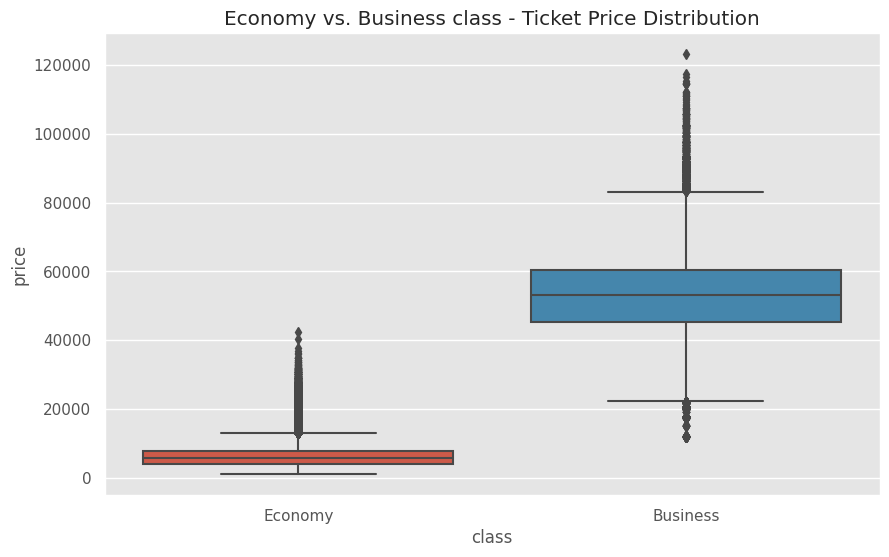

In [65]:
sns.boxplot(data=df,x='class',y='price')
plt.title('Economy vs. Business class - Ticket Price Distribution')
plt.show()

The Business class has a much higher median and a wider interquartile range (IQR), indicating more variability. The Economy class has a lower median and is more tightly clustered, though both categories show a significant number of outliers, especially at the high end.

In [59]:
economy=df[df['class']=='Economy']
business=df[df['class']=='Business']
print(f"Economy median: {economy['price'].median()}")
print(f"Economy mean: {economy['price'].mean().round(2)}")
print(f"Business median: {business['price'].median()}")
print(f"Business mean: {business['price'].mean().round(2)}")

Economy median: 5772.0
Economy mean: 6572.34
Business median: 53164.0
Business mean: 52471.44


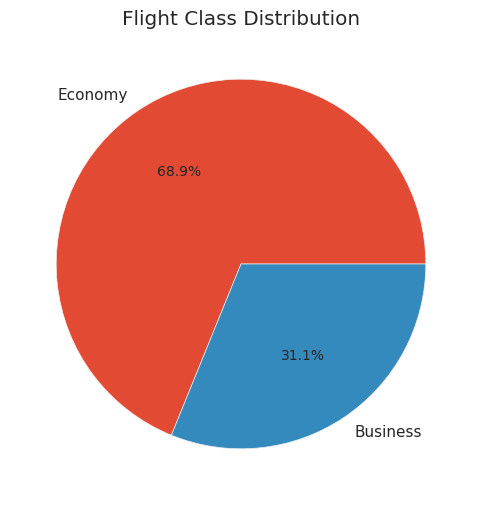

In [124]:
class_counts = df['class'].value_counts()
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%')
plt.title('Flight Class Distribution')
plt.show()

Approximately 60% people choose to fly Economy class compared to Business class, an understandable trend given that Economy tickets average around **₹6,000** (*70 USD*), while Business class tickets cost approximately **₹50,000** (*600 USD*).

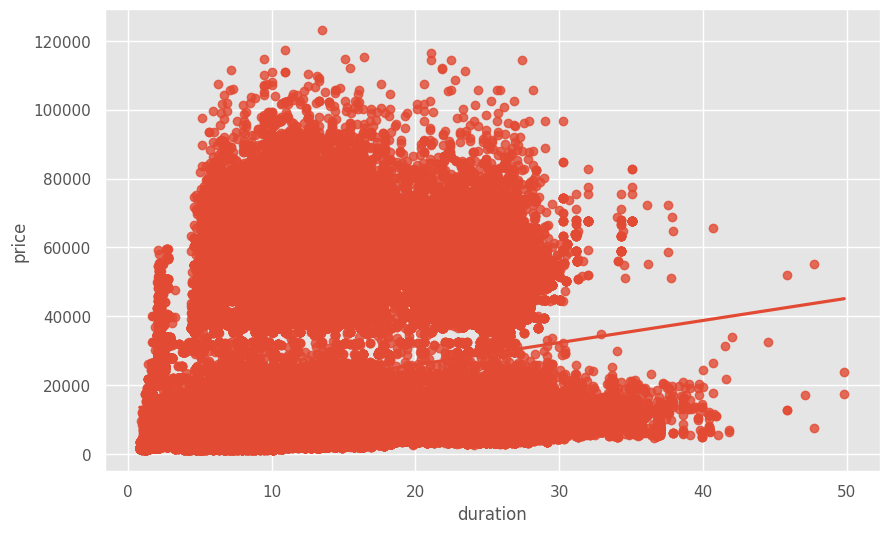

In [66]:
sns.regplot(data=df,x='duration',y='price')
plt.show()

There's no clear linear relationship between duration and price — for short and medium durations, price can vary greatly.

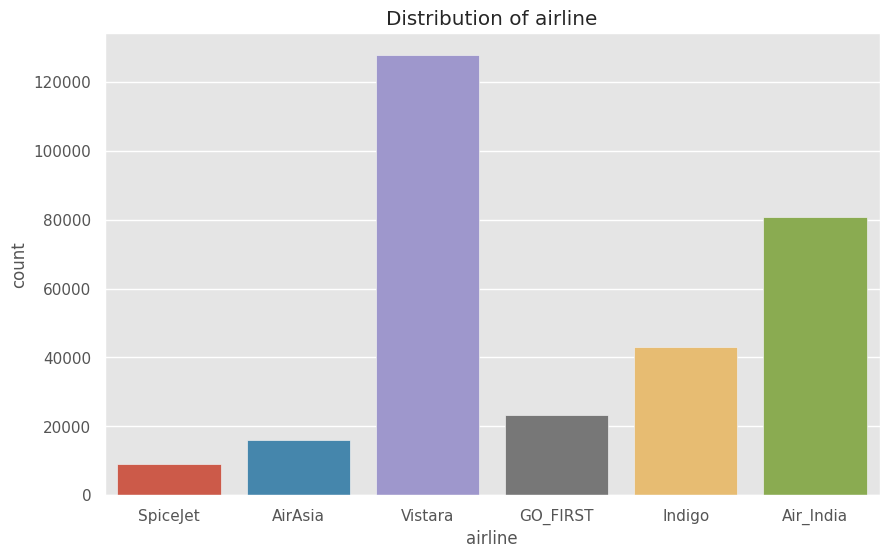

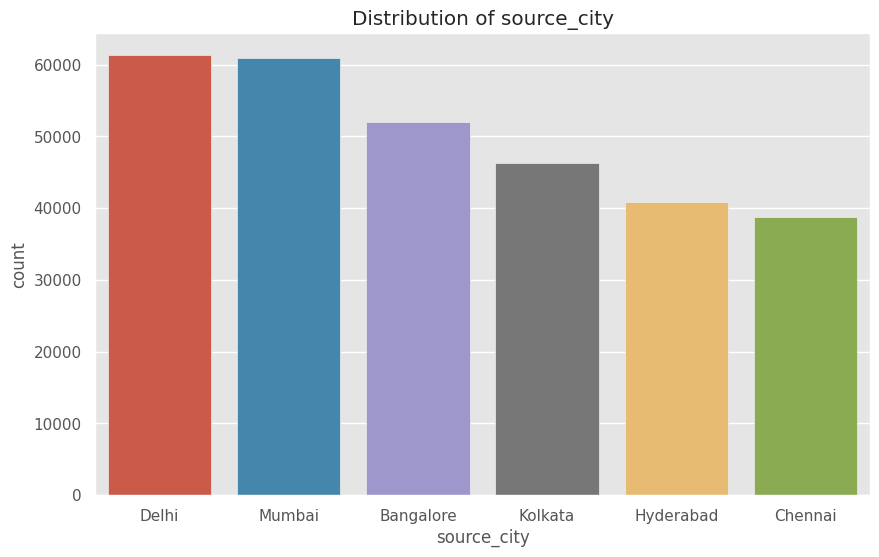

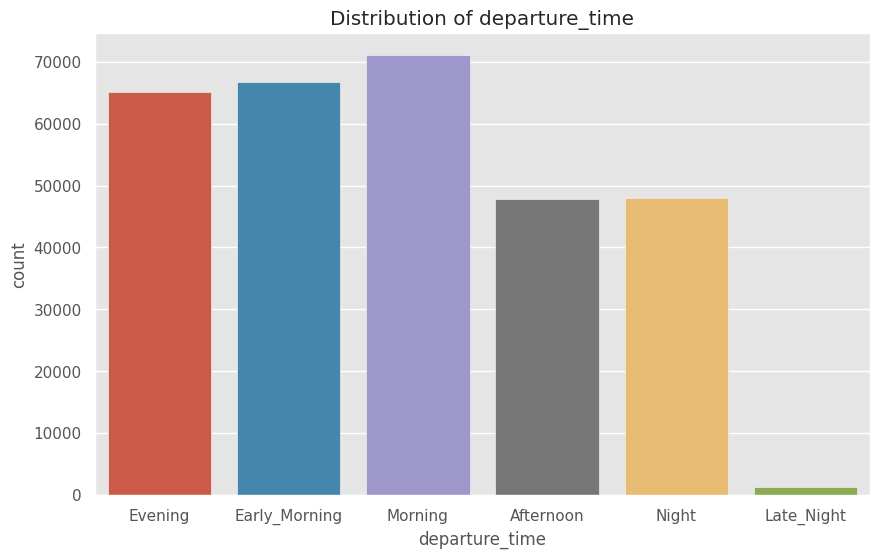

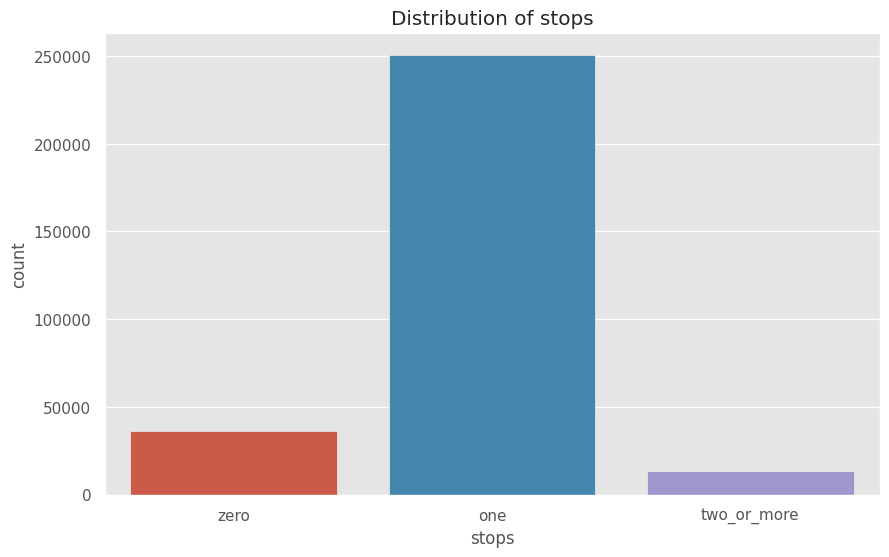

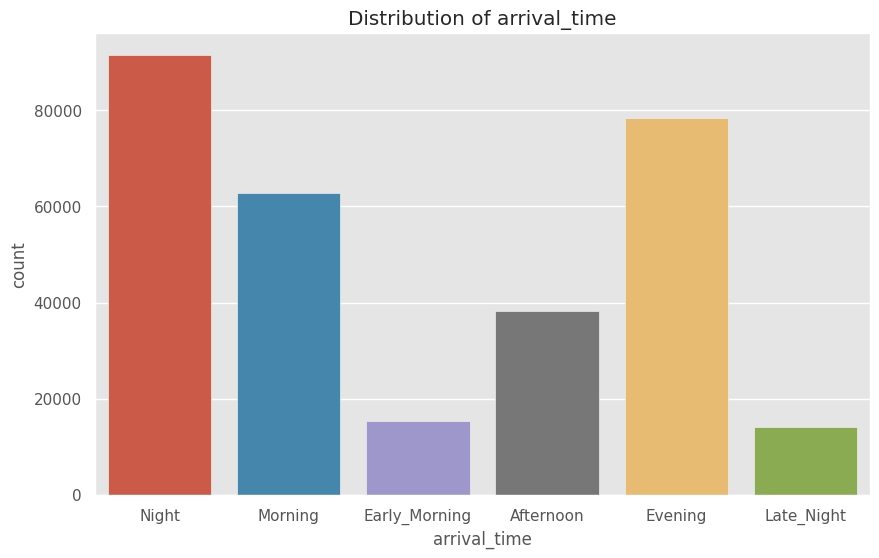

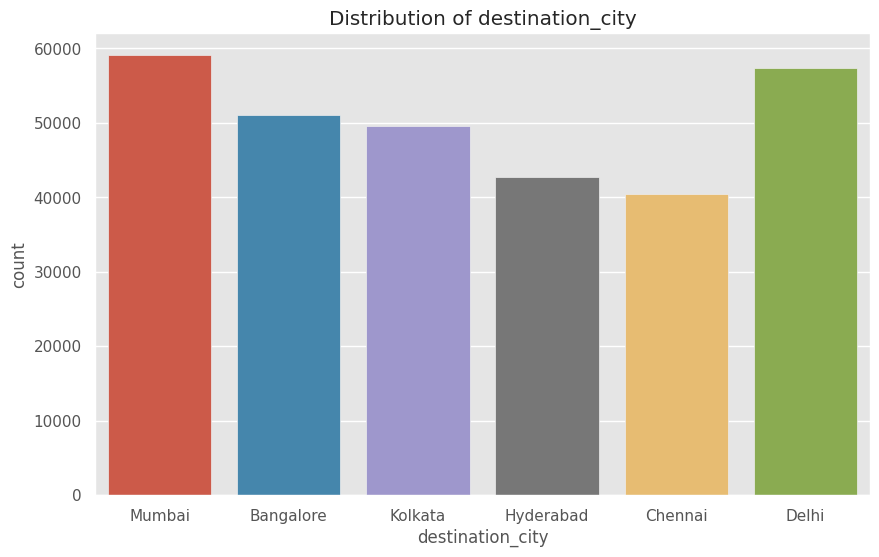

In [122]:
cat_cols=df.select_dtypes(include=object).drop(columns={'flight','class'},axis=1)
for col in cat_cols:
    sns.countplot(data=df,x=col)
    plt.title(f"Distribution of {col}")
    plt.show()

The bar plots show that most people prefer flying with **Vistara**. In terms of cities, **Mumbai** and **Delhi** are the most common for both departures and arrivals. The Delhi-Mumbai route is one of the busiest air routes in India, with a large number of flights and passengers. There are approximately **740** flights per week flying from Mumbai to Indira Gandhi International (Delhi), which explains the large number of flights on this route. Many travelers choose **morning** flights with **one stop**, and most arrivals occur in the **evening** or **late at night**.

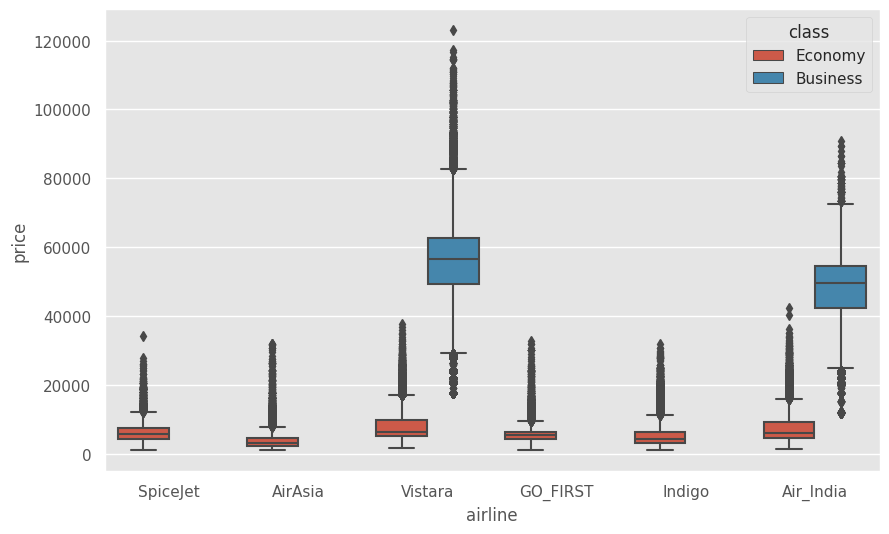

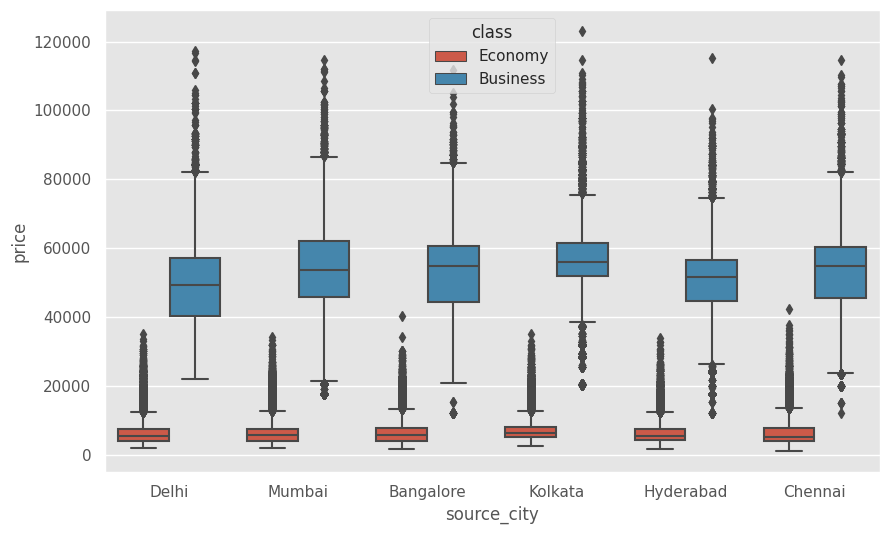

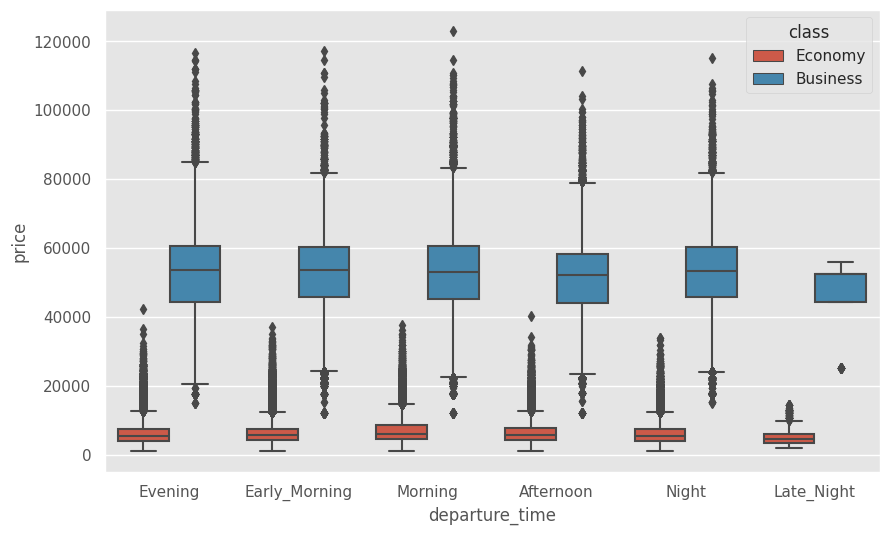

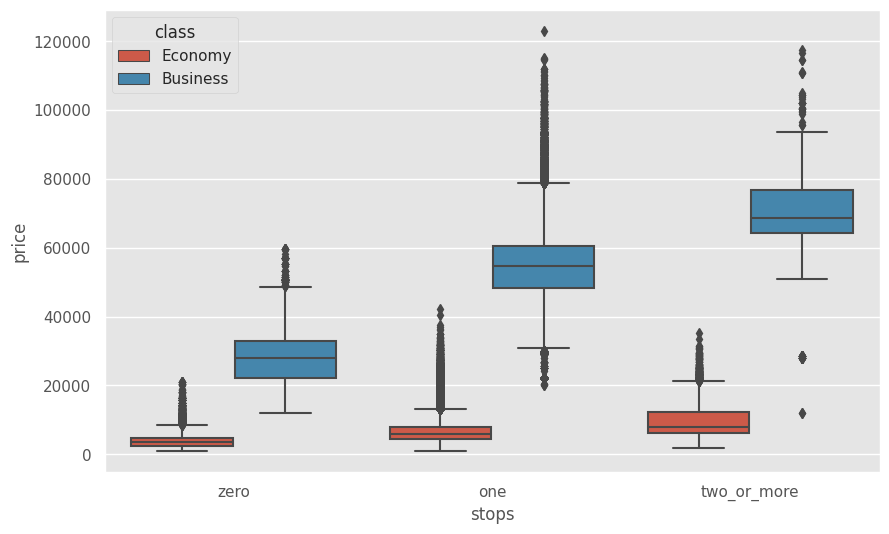

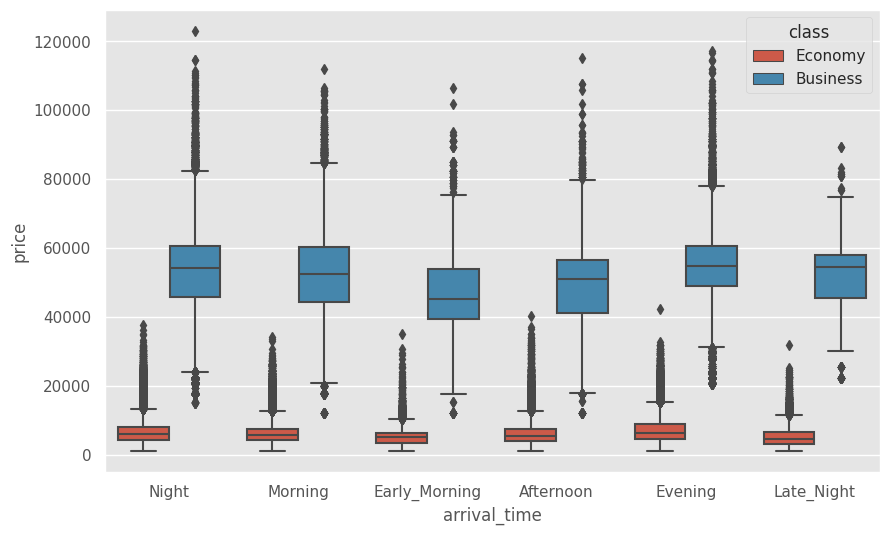

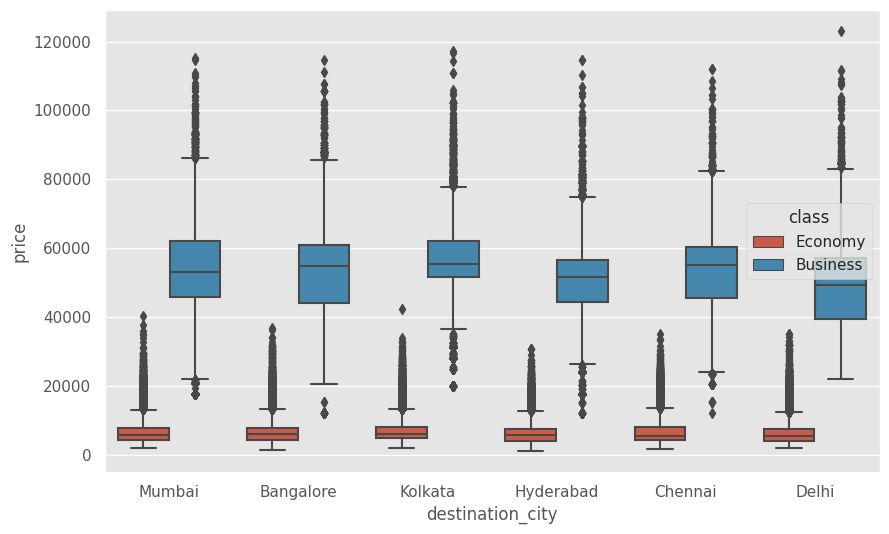

In [125]:
for col in cat_cols:
    sns.boxplot(data=df,x=col,y='price',hue='class')
    plt.show()

### 4. Feature Engineering

In [22]:
percentile25=df['price'].quantile(0.25)
percentile75=df['price'].quantile(0.75)
IQR=percentile75-percentile25
upper_limit=percentile75+1.5*IQR
lower_limit=percentile75-1.5*IQR
print('Upper: ',upper_limit)
print('Lower: ',lower_limit)

Upper:  99128.0
Lower:  -14086.0


In [69]:
df=df[(df['price']>lower_limit)&(df['price']<upper_limit)]
df.reset_index(drop='True',inplace=True)

In [70]:
cat_cols=df.select_dtypes(include=object)
for col in cat_cols:
    print(f"\nColumn: {col}")
    print(f"Unique values ({df[col].nunique()}): {df[col].unique()}")
    print("-" * 40)


Column: airline
Unique values (6): ['SpiceJet' 'AirAsia' 'Vistara' 'GO_FIRST' 'Indigo' 'Air_India']
----------------------------------------

Column: flight
Unique values (1561): ['SG-8709' 'SG-8157' 'I5-764' ... '6E-7127' '6E-7259' 'AI-433']
----------------------------------------

Column: source_city
Unique values (6): ['Delhi' 'Mumbai' 'Bangalore' 'Kolkata' 'Hyderabad' 'Chennai']
----------------------------------------

Column: departure_time
Unique values (6): ['Evening' 'Early_Morning' 'Morning' 'Afternoon' 'Night' 'Late_Night']
----------------------------------------

Column: stops
Unique values (3): ['zero' 'one' 'two_or_more']
----------------------------------------

Column: arrival_time
Unique values (6): ['Night' 'Morning' 'Early_Morning' 'Afternoon' 'Evening' 'Late_Night']
----------------------------------------

Column: destination_city
Unique values (6): ['Mumbai' 'Bangalore' 'Kolkata' 'Hyderabad' 'Chennai' 'Delhi']
----------------------------------------

Column: c

In [71]:
# Category Columns Transformation
part_of_day={'Early_Morning':0,'Morning':1,'Afternoon':2,'Evening':3,'Night':4,'Late_Night':5}
df['departure_time']=df['departure_time'].map(part_of_day)
df['arrival_time']=df['arrival_time'].map(part_of_day)
classs={'Economy':0,'Business':1}
df['class']=df['class'].map(classs)
df['stops'].replace({'zero':0,'one':1,'two_or_more':2},inplace=True)

In [72]:
df['flight']=df['flight'].str.split('-').str[0]
df['flight'].value_counts()

flight
UK    127736
AI     80892
6E     43120
G8     23173
I5     16098
SG      9011
Name: count, dtype: int64

In [73]:
dummies=pd.get_dummies(df[['airline','source_city','destination_city','flight']],drop_first=True).astype(int) 
df = pd.concat([df, dummies], axis=1)
df = df.drop(['airline', 'source_city', 'destination_city','flight'], axis=1)

In [74]:
df.head()

,departure_time,stops,arrival_time,class,duration,days_left,price,airline_Air_India,airline_GO_FIRST,airline_Indigo,airline_SpiceJet,airline_Vistara,source_city_Chennai,source_city_Delhi,source_city_Hyderabad,source_city_Kolkata,source_city_Mumbai,destination_city_Chennai,destination_city_Delhi,destination_city_Hyderabad,destination_city_Kolkata,destination_city_Mumbai,flight_AI,flight_G8,flight_I5,flight_SG,flight_UK
0,3,0,4,0,2.17,1,5953,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
1,0,0,1,0,2.33,1,5953,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
2,0,0,0,0,2.17,1,5956,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0
3,1,0,2,0,2.25,1,5955,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1
4,1,0,1,0,2.33,1,5955,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1


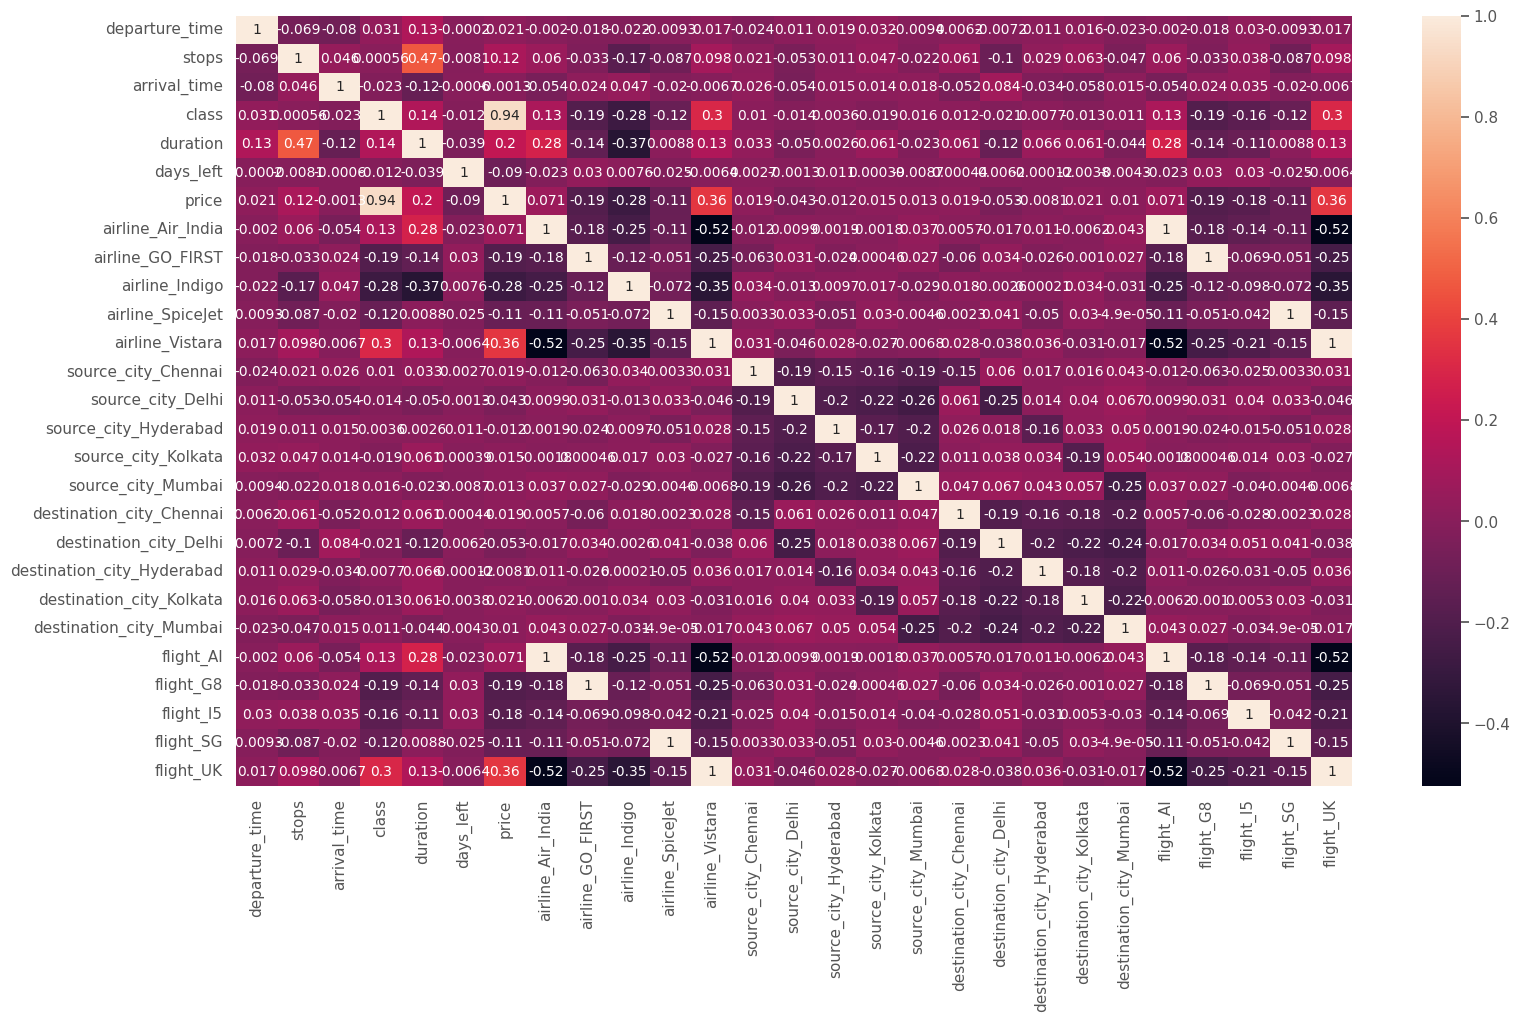

In [80]:
plt.figure(figsize=(18,10))
sns.heatmap(df.corr(),annot=True)
plt.show()

### 5. Model Building

In [85]:
X=df.drop('price',axis=1)
y=df['price']

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=2)

In [86]:
scaler = StandardScaler()

X_train['duration'] = scaler.fit_transform(X_train[['duration']])
X_test['duration'] = scaler.transform(X_test[['duration']])

scaler = StandardScaler()
X_train['days_left'] = scaler.fit_transform(X_train[['days_left']])
X_test['days_left'] = scaler.transform(X_test[['days_left']])

#### 5.1. Linear Regression

Coef: [-5.96904041e+01  5.55103790e+03  3.09312067e+02  4.50930819e+04
  6.46967714e+02 -1.73351988e+03 -7.06722465e+02  1.49308429e+02
  6.99049778e+02  3.72075392e+02  1.29049258e+03 -1.83238190e+02
 -1.59258522e+03 -1.71978639e+03  1.41752568e+03 -2.73050938e+02
 -3.20735060e+02 -1.52956313e+03 -1.80857991e+03  1.35407564e+03
  4.08213438e+01 -7.06722465e+02  1.49308429e+02 -1.80420371e+03
  3.72075392e+02  1.29049258e+03]
Intercept: 982.6437253501899
MSE 45621784.24892355
R2:  0.9111671697026479
MAE:  4510.938284330939


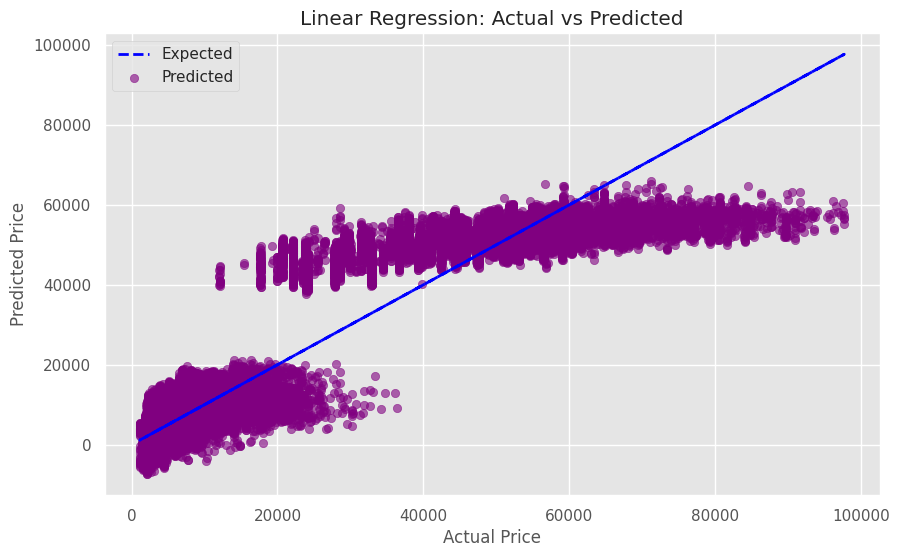

In [95]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

print('Coef:',lr.coef_)
print('Intercept:',lr.intercept_)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print('MSE', mse)
print('R2: ',r2)
print('MAE: ',mae)

plt.plot(y_test, y_test, color='blue', linestyle='--', linewidth=2, label='Expected')
plt.scatter(y_test, y_pred, color='purple', alpha=0.6, label='Predicted')

plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Linear Regression: Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.show()

#### 5.2. Ridge Regression

Ridge Coef: [-5.96915303e+01  5.55074630e+03  3.09319066e+02  4.50919738e+04
  6.47002486e+02 -1.73351306e+03 -7.06565516e+02  1.49235968e+02
  6.98867061e+02  3.71950786e+02  1.29068104e+03 -1.83162765e+02
 -1.59248418e+03 -1.71967428e+03  1.41754970e+03 -2.72979297e+02
 -3.20653361e+02 -1.52947127e+03 -1.80846998e+03  1.35411943e+03
  4.08830942e+01 -7.06565516e+02  1.49235968e+02 -1.80416935e+03
  3.71950786e+02  1.29068104e+03]
Ridge Intercept: 982.9123102743943
Ridge MSE: 45621783.35780506
Ridge R2: 0.9111671714377966
Ridge MAE: 4510.933165896339


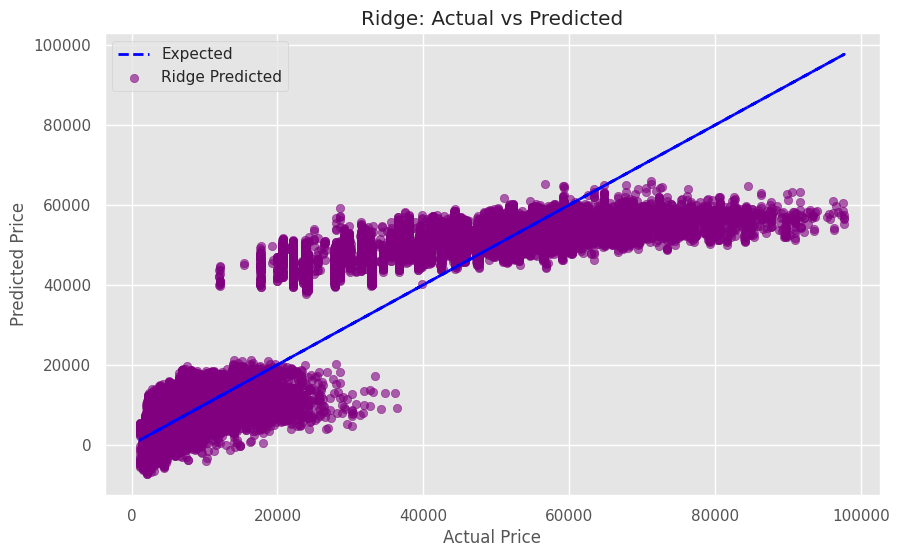

In [109]:
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)

print('Ridge Coef:', ridge.coef_)
print('Ridge Intercept:', ridge.intercept_)

r2 = r2_score(y_test, y_pred_ridge)
mae = mean_absolute_error(y_test, y_pred_ridge)
mse = mean_squared_error(y_test, y_pred_ridge)
print('Ridge MSE:', mse)
print('Ridge R2:', r2)
print('Ridge MAE:', mae)

plt.plot(y_test, y_test, color='blue', linestyle='--', linewidth=2, label='Expected')
plt.scatter(y_test, y_pred_ridge, color='purple', alpha=0.6, label='Ridge Predicted')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Ridge: Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.show()

#### 5.3. Lasso

Lasso Coef: [-5.97017813e+01  5.55007033e+03  3.09254492e+02  4.50926393e+04
  6.47177363e+02 -1.73346363e+03 -2.18454925e+03 -3.36621475e+02
  0.00000000e+00  4.21836891e+01  1.88246908e+03 -1.80281886e+02
 -1.59001934e+03 -1.71696018e+03  1.41876099e+03 -2.70727122e+02
 -3.18838214e+02 -1.52787951e+03 -1.80672935e+03  1.35440649e+03
  4.13865292e+01  7.20180802e+01 -6.20055562e+01 -2.50080368e+03
  0.00000000e+00 -0.00000000e+00]
Lasso Intercept: 1679.5439392987464
Lasso MSE: 45621597.998077944
Lasso R2: 0.911167532362505
Lasso MAE: 4510.834271846584


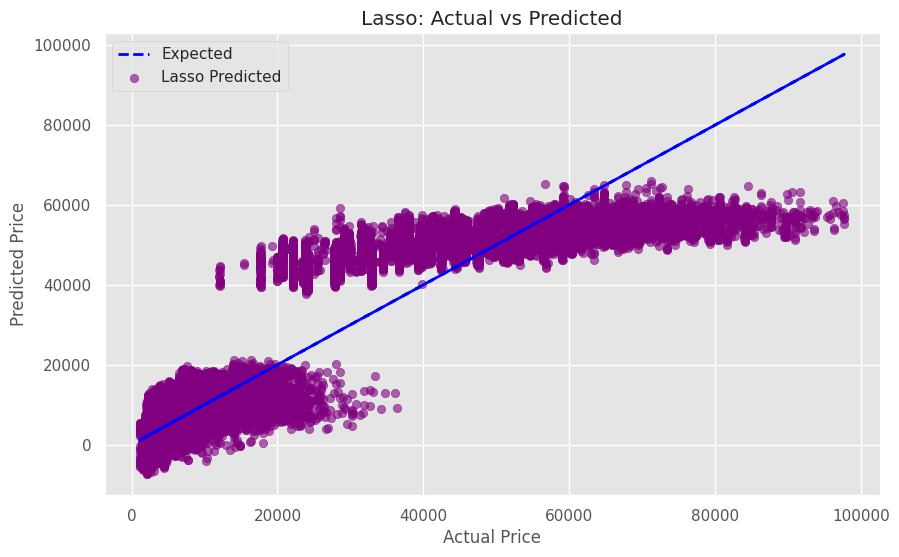

In [108]:
lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)

y_pred_lasso = lasso.predict(X_test)

print('Lasso Coef:', lasso.coef_)
print('Lasso Intercept:', lasso.intercept_)

r2 = r2_score(y_test, y_pred_lasso)
mae = mean_absolute_error(y_test, y_pred_lasso)
mse = mean_squared_error(y_test, y_pred_lasso)
print('Lasso MSE:', mse)
print('Lasso R2:', r2)
print('Lasso MAE:', mae)

plt.plot(y_test, y_test, color='blue', linestyle='--', linewidth=2, label='Expected')
plt.scatter(y_test, y_pred_lasso, color='purple', alpha=0.6, label='Lasso Predicted')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Lasso: Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.show()

#### 5.4. Random Forest Regressor

In [91]:
rf = RandomForestRegressor(random_state=2, n_jobs=-1)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

random_search_rf = RandomizedSearchCV(rf,param_grid,n_iter=50,               
    scoring='neg_mean_squared_error',cv=5,random_state=42,n_jobs=-1,verbose=2
)

random_search_rf.fit(X_train, y_train)

print("Best Params:", random_search_rf.best_params_)
print("Best R² score:", random_search_rf.best_score_)
print("Best RMSE:", (-random_search_rf.best_score_)**0.5)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END max_depth=30, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time= 2.1min
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 2.0min
[CV] END max_depth=30, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time= 2.1min
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 2.0min
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 1.9min
[CV] END max_depth=30, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time= 2.1min
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 2.0min
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=20

Test R²: 0.985
Test MAE: 1,270
Test MSE: 7608312.775
RMSE: 2758.32


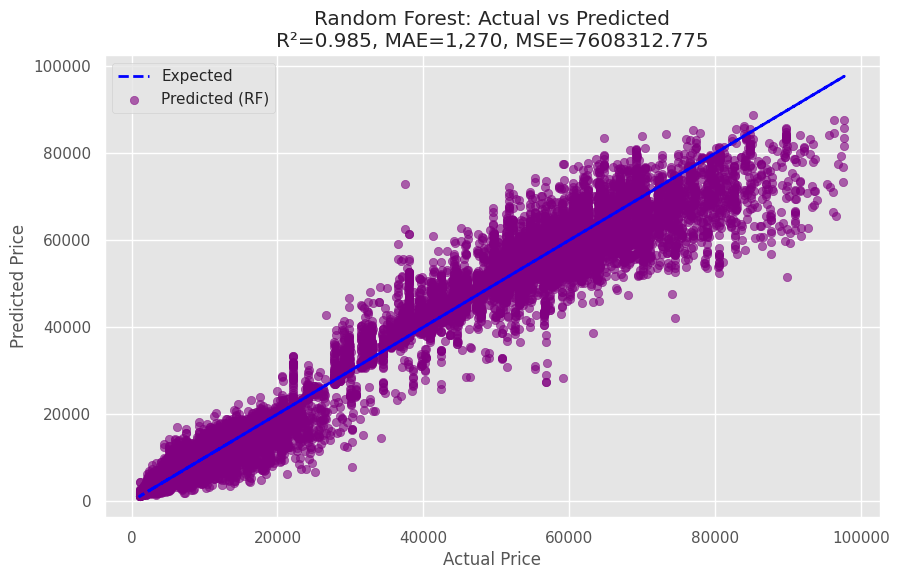

In [93]:
best_rf = random_search_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)

r2 = r2_score(y_test, y_pred_rf)
mae = mean_absolute_error(y_test, y_pred_rf)
mse = mean_squared_error(y_test, y_pred_rf)
rmse = np.sqrt(mse)

print(f"Test R²: {r2:.3f}")
print(f"Test MAE: {mae:,.0f}")
print(f"Test MSE: {mse:.3f}")
print(f"RMSE: {rmse:.2f}")

plt.plot(y_test, y_test, color='blue', linestyle='--', linewidth=2, label='Expected')
plt.scatter(y_test, y_pred_rf, color='purple', alpha=0.6, label='Predicted (RF)')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title(f'Random Forest: Actual vs Predicted\nR²={r2:.3f}, MAE={mae:,.0f}, MSE={mse:.3f}')
plt.legend()
plt.grid(True)
plt.show()

#### 5.5. Gradient Boost Regressor

In [96]:
gbr= GradientBoostingRegressor()

param_grid = {
    'n_estimators': [100, 300, 500],           
    'learning_rate': [0.01, 0.1, 0.2],             
    'max_depth': [5, 10, 15],                         
    'min_samples_split': [2, 5, 10],                    
    'min_samples_leaf': [1, 2, 4],                       
    'max_features': ['sqrt', 'log2'],                         
}

random_search_gbr = RandomizedSearchCV(gbr,param_grid,n_iter=30,               
    scoring='neg_mean_squared_error',cv=5,random_state=42,n_jobs=-1,verbose=2
)

random_search_gbr.fit(X_train, y_train)

print("Best Params:", random_search_gbr.best_params_)
print("Best R² score:", random_search_gbr.best_score_)
print("Best RMSE:", (-random_search_gbr.best_score_)**0.5)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time= 1.4min
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time= 1.3min
[CV] END learning_rate=0.2, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=  35.0s
[CV] END learning_rate=0.1, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time= 1.7min
[CV] END learning_rate=0.1, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time= 1.7min
[CV] END learning_rate=0.2, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time= 2.8min
[CV] END learning_rate=0.2, max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time= 2.8min


Test R²: 0.988
Test MAE: 1,240
Test MSE: 6255107.713
RMSE: 2501.02


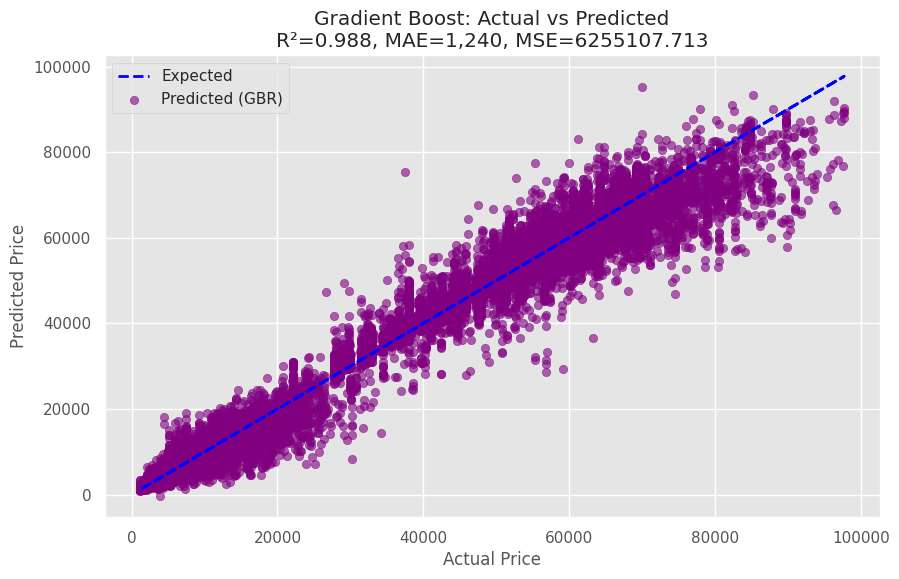

In [107]:
best_gbr = random_search_gbr.best_estimator_
y_pred_gbr = best_gbr.predict(X_test)

r2 = r2_score(y_test, y_pred_gbr)
mae = mean_absolute_error(y_test, y_pred_gbr)
mse = mean_squared_error(y_test, y_pred_gbr)
rmse = np.sqrt(mse)

print(f"Test R²: {r2:.3f}")
print(f"Test MAE: {mae:,.0f}")
print(f"Test MSE: {mse:.3f}")
print(f"RMSE: {rmse:.2f}")

plt.plot(y_test, y_test, color='blue', linestyle='--', linewidth=2, label='Expected')
plt.scatter(y_test, y_pred_gbr, color='purple', alpha=0.6, label='Predicted (GBR)')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title(f'Gradient Boost: Actual vs Predicted\nR²={r2:.3f}, MAE={mae:,.0f}, MSE={mse:.3f}')
plt.legend()
plt.grid(True)
plt.show()

#### 5.6. XGB Regressor

In [98]:
param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'gamma': [0, 1, 5],
    'reg_alpha': [0, 0.01, 0.1, 1],
    'reg_lambda': [1, 1.5, 2],
    'min_child_weight': [1, 3, 5],
}

xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

random_search_xgb = RandomizedSearchCV(xgb,param_grid,n_iter=50,scoring='neg_mean_squared_error',
    cv=5,verbose=1,n_jobs=-1)

random_search_xgb.fit(X_train, y_train)

print("Best Params:", random_search_xgb.best_params_)
print("Best R² score:", random_search_xgb.best_score_)
print("Best RMSE:", (-random_search_xgb.best_score_)**0.5)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Params: {'reg_lambda': 2, 'reg_alpha': 1, 'n_estimators': 500, 'min_child_weight': 1, 'max_depth': 10, 'learning_rate': 0.1, 'gamma': 5}
Best R² score: -5967469.341123914
Best RMSE: 2442.8404248177803


Test R²: 0.989
Test MAE: 1,184
Test MSE: 5885683.774
RMSE: 2426.04


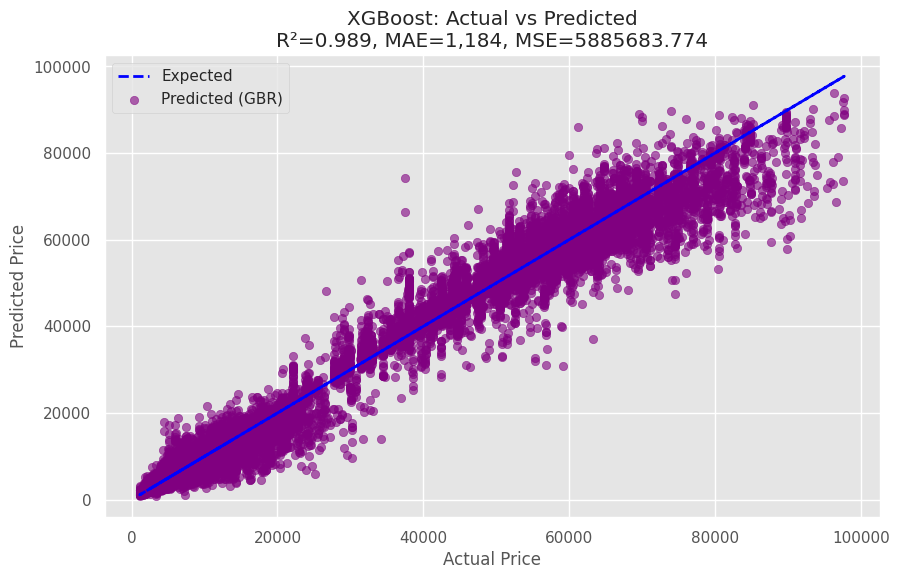

In [106]:
best_xgb = random_search_xgb.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)

r2 = r2_score(y_test, y_pred_xgb)
mae = mean_absolute_error(y_test, y_pred_xgb)
mse = mean_squared_error(y_test, y_pred_xgb)
rmse = np.sqrt(mse)

print(f"Test R²: {r2:.3f}")
print(f"Test MAE: {mae:,.0f}")
print(f"Test MSE: {mse:.3f}")
print(f"RMSE: {rmse:.2f}")

plt.plot(y_test, y_test, color='blue', linestyle='--', linewidth=2, label='Expected')
plt.scatter(y_test, y_pred_xgb, color='purple', alpha=0.6, label='Predicted (GBR)')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title(f'XGBoost: Actual vs Predicted\nR²={r2:.3f}, MAE={mae:,.0f}, MSE={mse:.3f}')
plt.legend()
plt.grid(True)
plt.show()

#### 5.7. CatBoost Regressor

In [101]:
cat_param_grid = {'iterations': [300, 500, 700],
    'depth': [6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'l2_leaf_reg': [1, 3, 5, 7, 9],
    'border_count': [32, 64, 128],
    'bagging_temperature': [0.0, 0.5, 1.0],
    'random_strength': [0.5, 1, 2]
}

cat = CatBoostRegressor(verbose=0, random_state=42)

random_search_cat = RandomizedSearchCV(cat,cat_param_grid,n_iter=30,scoring='neg_mean_squared_error',
    cv=5,verbose=1,n_jobs=-1,random_state=42
)

random_search_cat.fit(X_train, y_train)
print("Best Params:", random_search_cat.best_params_)
print("Best Neg MSE:", random_search_cat.best_score_)
print("Best RMSE:", (-random_search_cat.best_score_) ** 0.5)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Params: {'random_strength': 1, 'learning_rate': 0.1, 'l2_leaf_reg': 7, 'iterations': 700, 'depth': 10, 'border_count': 128, 'bagging_temperature': 1.0}
Best Neg MSE: -8725402.13610571
Best RMSE: 2953.879167485649


Test R²: 0.983
Test MAE: 1,618
Test MSE: 8593584.349
RMSE: 2931.48


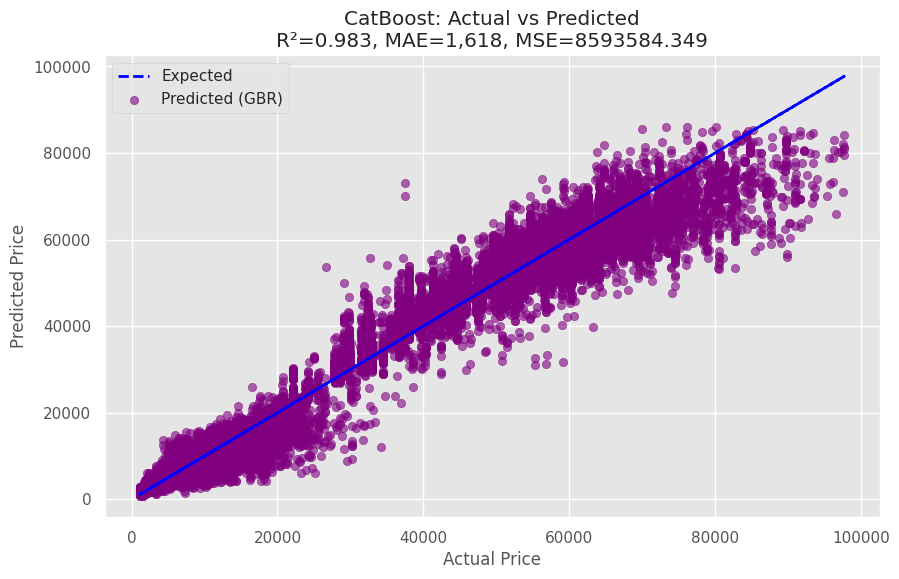

In [105]:
best_cat = random_search_cat.best_estimator_
y_pred_cat = best_cat.predict(X_test)

r2 = r2_score(y_test, y_pred_cat)
mae = mean_absolute_error(y_test, y_pred_cat)
mse = mean_squared_error(y_test, y_pred_cat)
rmse = np.sqrt(mse)

print(f"Test R²: {r2:.3f}")
print(f"Test MAE: {mae:,.0f}")
print(f"Test MSE: {mse:.3f}")
print(f"RMSE: {rmse:.2f}")

plt.plot(y_test, y_test, color='blue', linestyle='--', linewidth=2, label='Expected')
plt.scatter(y_test, y_pred_cat, color='purple', alpha=0.6, label='Predicted (GBR)')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title(f'CatBoost: Actual vs Predicted\nR²={r2:.3f}, MAE={mae:,.0f}, MSE={mse:.3f}')
plt.legend()
plt.grid(True)
plt.show()

### 6. Results and Evaluation

In [104]:
fitted_models = [
    ("Linear Regression", lr),
    ("Ridge Regression", ridge),
    ("Lasso Regression", lasso),
    ("Random Forest Regressor", best_rf),
    ("Gradient Boosting Regressor", best_gbr),
    ("XGBoost Regressor", best_xgb),
    ("CatBoost Regressor", best_cat),
    
]

results = []

for name, model in fitted_models:
    train_r2 = model.score(X_train, y_train)
    test_r2 = model.score(X_test, y_test)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mse ** 0.5

    results.append({
        "Model": name,
        "Train R² Score": train_r2,
        "Test R² Score": test_r2,
        "Mean Squared Error": mse,
        "Mean Absolute Error": mae,
        "Root Mean Squared Error": rmse
    })

results_df = pd.DataFrame(results)
results_df

,Model,Train R² Score,Test R² Score,Mean Squared Error,Mean Absolute Error,Root Mean Squared Error
0,Linear Regression,0.910858,0.911167,4.562178e+07,4510.938284,6754.389998
1,Ridge Regression,0.910858,0.911167,4.562178e+07,4510.933166,6754.389932
2,Lasso Regression,0.910858,0.911168,4.562160e+07,4510.834272,6754.376211
3,Random Forest Regressor,0.994269,0.985185,7.608313e+06,1270.130209,2758.317019
4,Gradient Boosting Regressor,0.993663,0.987820,6.255108e+06,1240.349299,2501.021334
5,XGBoost Regressor,0.994512,0.988540,5.885684e+06,1184.330778,2426.042822
6,CatBoost Regressor,0.985247,0.983267,8.593584e+06,1617.796061,2931.481596


The **Linear Regression**, **Ridge Regression**, and **Lasso Regression** models all perform similarly, achieving a respectable ***R² score*** of **~0.91** on both training and test sets. However, their error metrics, ***Mean Squared Error (MSE)*** and ***Root Mean Squared Error (RMSE)***, remain relatively high compared to more advanced models.

The **Random Forest Regressor**, **Gradient Boosting Regressor**, **XGBoost Regressor**, and **CatBoost Regressor** all significantly outperform linear models. Among these, **XGBoost Regressor** achieved the best overall performance, with the highest Test ***R² score*** **(0.9885)** and the lowest errors (*MSE*, *MAE*, and *RMSE*), indicating excellent generalization capability and predictive accuracy.

**Gradient Boosting** and **Random Forest** also provided very strong results, with minor differences. Interestingly, **CatBoost** slightly lagged behind other ensemble methods but still substantially outperformed linear models.

Ensemble methods, particularly **XGBoost**, are the most effective for this problem, providing superior accuracy and lower error.

In [114]:
prediction_df = y_test.to_frame()
prediction_df['price_pred'] = best_xgb.predict(X_test)
prediction_df.head(10)

,price,price_pred
4734,3001,3090.168457
69343,5667,5908.481445
160314,9707,8744.484375
241294,17604,17590.062500
262339,66063,68659.976562
205275,6966,7223.053223
29514,9840,9787.243164
34827,3855,4860.603516
203352,21948,24017.892578
175586,6942,6365.269531
